In [1]:
#!pip install gensim

In [ ]:
#pip install --force-reinstall --upgrade scipy==1.10.1


In [63]:
import os
import sys # to setup our utility functions
sys.path.append('../') # relative folder in which our utility functions can be found
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
import spacy
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from yellowbrick.cluster import  SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.cluster import HDBSCAN

In [3]:
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
spacy_model = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
train_path = 'aclImdb/train'
print(Path(train_path + '/unsup').resolve())

In [ ]:
def load_corpus_from_folder(folder_path):
    corpus = []
    for file_path in Path(folder_path).glob("*.txt"):
        with open(file_path, encoding="utf-8") as f:
            corpus.append(f.read().strip())
    return corpus


In [ ]:
unsup_corpus = load_corpus_from_folder(Path(train_path + '/unsup'))
df_unsup = pd.DataFrame({'text': unsup_corpus})

In [ ]:
print(df_unsup.head())
print(len(df_unsup))

In [ ]:
df_unsup.to_csv("df_unsup.csv", index=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_unsup = pd.read_csv("/content/drive/MyDrive/unsup/df_unsup.csv")

In [ ]:
print(df_unsup.head())
print(len(df_unsup))

   Unnamed: 0                                               text
0           0  I admit, the great majority of films released ...
1           1  Take a low budget, inexperienced actors doubli...
2           2  Everybody has seen 'Back To The Future,' right...
3           3  Doris Day was an icon of beauty in singing and...
4           4  After a series of silly, fun-loving movies, 19...
50000


In [ ]:
df_unsup['char_count'] = df_unsup['text'].apply(len) # number of characters
df_unsup['word_count'] = df_unsup['text'].apply(lambda x: len(word_tokenize(x))) # number of words
df_unsup['avg_word_length'] = df_unsup['char_count'] / df_unsup['word_count'] # not quite useful but yeah... why not ?
df_unsup.head()

Unnamed: 0                                               text  char_count  \
0           0  I admit, the great majority of films released ...         791   
1           1  Take a low budget, inexperienced actors doubli...         913   
2           2  Everybody has seen 'Back To The Future,' right...        1813   
3           3  Doris Day was an icon of beauty in singing and...         697   
4           4  After a series of silly, fun-loving movies, 19...        1186   

   word_count  avg_word_length  
0         189         4.185185  
1         181         5.044199  
2         412         4.400485  
3         135         5.162963  
4         252         4.706349

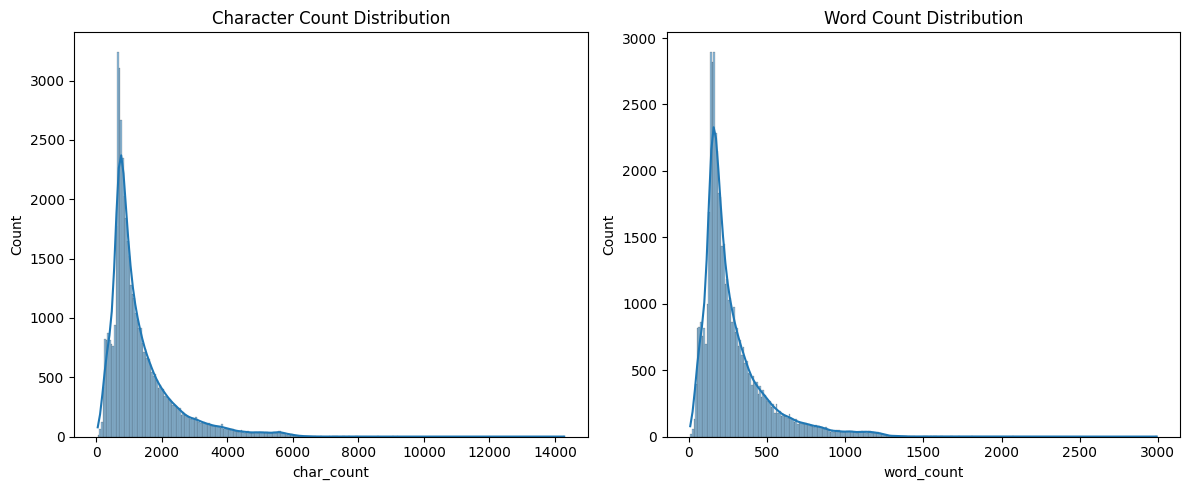

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_unsup['char_count'], kde=True, ax=axes[0])
axes[0].set_title('Character Count Distribution')

sns.histplot(df_unsup['word_count'], kde=True, ax=axes[1])
axes[1].set_title('Word Count Distribution')

plt.tight_layout()
plt.show()

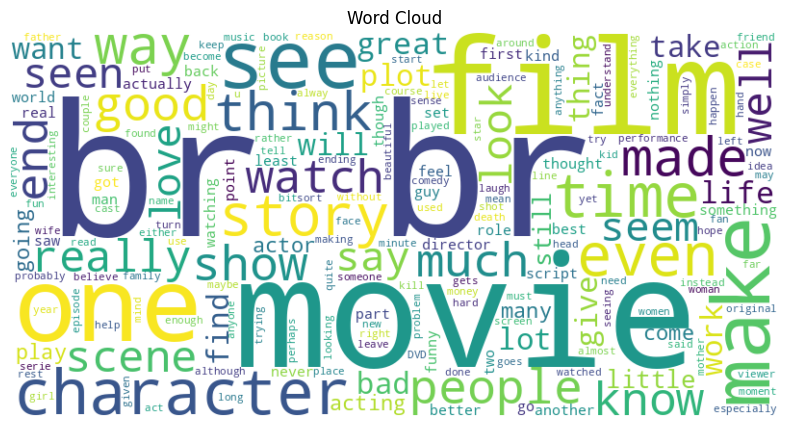

In [ ]:
text_all = " ".join(df_unsup['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()


# Cleaning

In [6]:
def remove_specific_words(df, text_column='commentaire', words_to_remove=None):
    """
    Supprime certains mots spécifiques d'une colonne de texte dans un DataFrame.

    - words_to_remove : liste de mots à supprimer
    """
    if words_to_remove is None:
        words_to_remove = []

    # Compile une expression régulière pour enlever les mots ciblés
    pattern = r'\b(?:' + '|'.join(re.escape(word.lower()) for word in words_to_remove) + r')\b'

    # Appliquer le nettoyage ligne par ligne
    df[text_column] = df[text_column].apply(lambda x: re.sub(pattern, '', x.lower(), flags=re.IGNORECASE))
    df[text_column] = df[text_column].str.replace(r'\s+', ' ', regex=True).str.strip()  # nettoyage des espaces
    return df


In [13]:
# Exemple de mots à retirer
stop_words_custom = ['film', 'movie', 'br','one']

# Nettoyage
df_unsup['text'] = df_unsup['text'].str.lower()
df_unsup_clean = remove_specific_words(df_unsup, text_column='text', words_to_remove=stop_words_custom)

In [14]:
def clean_text(text, reduction_technique: str = "lem"):
    """
    Nettoie le texte : minuscule, suppression ponctuation, stopwords,
    et réduction morphologique (lemmatisation ou stemmatisation).
    """
    # Minuscule
    text = text.lower()

    # Supprimer la ponctuation
    text = ''.join([c for c in text if c not in string.punctuation])

    # Tokenisation
    tokens = nltk.word_tokenize(text)
    # Suppression des stopwords
    stop_words = stopwords.words('english')  # ou 'french' si tu veux
    tokens = [word for word in tokens if word not in stop_words]
    # Réduction morphologique
    if reduction_technique == "lem":
      lemmatizer = WordNetLemmatizer()
      words = [lemmatizer.lemmatize(token) for token in tokens]
    elif reduction_technique == "stem":
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in tokens]
    else:
        raise ValueError("reduction_technique must be 'lem' or 'stem'")

    return words, ' '.join(words)



In [15]:
# Test
text = "The children aren't playing happily in the playground :)."
print(clean_text(text, "lem"))  # version lemmatisée
print(clean_text(text, "stem")) # version stemmée

(['child', 'arent', 'playing', 'happily', 'playground'], 'child arent playing happily playground')
(['children', 'arent', 'play', 'happili', 'playground'], 'children arent play happili playground')


In [16]:
df_unsup[['tokens', 'clean_text']] = df_unsup['text'].apply(
    lambda x: pd.Series(clean_text(x, reduction_technique="lem"))
)

In [17]:
print(df_unsup['clean_text'].head)

<bound method NDFrame.head of 0        admit great majority film released say 1933 do...
1        take low budget inexperienced actor doubling p...
2        everybody seen back future right whether like ...
3        doris day icon beauty singing acting warm voic...
4        series silly funloving movie 1955 big year dor...
                               ...                        
49995    delightfully awful made david giancola guy ive...
49996    watching time chaser obvious made bunch friend...
49997    beginning see member troma team company uwe bo...
49998    incredible ever since saw 1977 told wife see r...
49999    tcm came acquiring wonderful silent comedydram...
Name: clean_text, Length: 50000, dtype: object>


In [ ]:
print(df_unsup['tokens'].head)

<bound method NDFrame.head of 0        [admit, great, majority, film, released, say, ...
1        [take, low, budget, inexperienced, actor, doub...
2        [everybody, seen, back, future, right, whether...
3        [doris, day, icon, beauty, singing, acting, wa...
4        [series, silly, funloving, movie, 1955, big, y...
                               ...                        
49995    [delightfully, awful, made, david, giancola, g...
49996    [watching, time, chaser, obvious, made, bunch,...
49997    [beginning, see, member, troma, team, company,...
49998    [incredible, ever, since, saw, 1977, told, wif...
49999    [tcm, came, acquiring, wonderful, silent, come...
Name: tokens, Length: 50000, dtype: object>


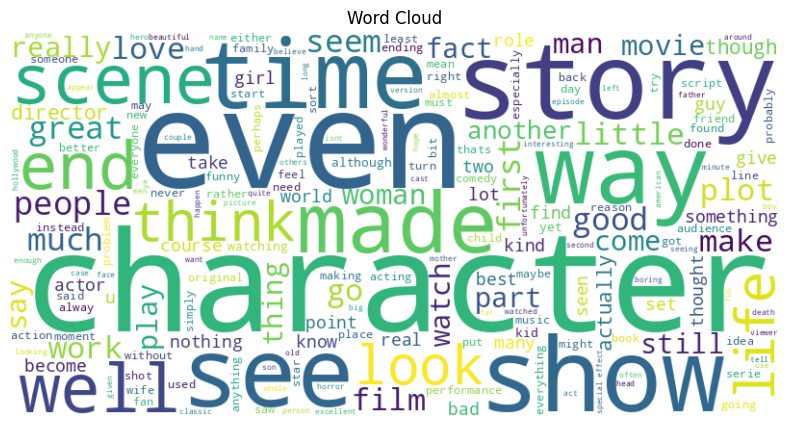

In [ ]:
text_all = " ".join(df_unsup['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()


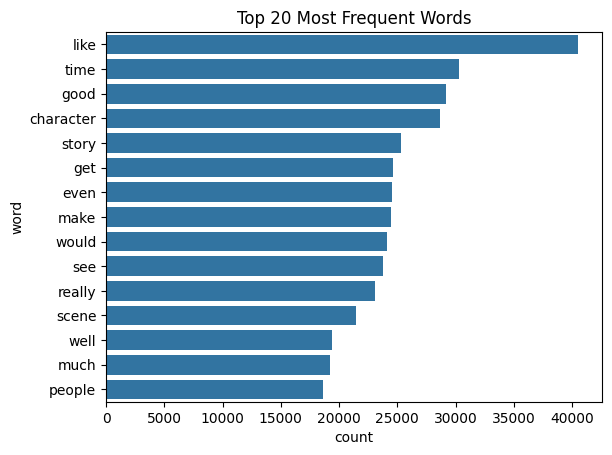

In [ ]:
all_tokens = word_tokenize(text_all)
top_words = Counter(all_tokens).most_common(15)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

sns.barplot(data=top_words_df, x='count', y='word')
plt.title("Top 20 Most Frequent Words")
plt.show()

In [ ]:
def get_top_ngrams(texts, ngram_range=(2,2), n=15):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

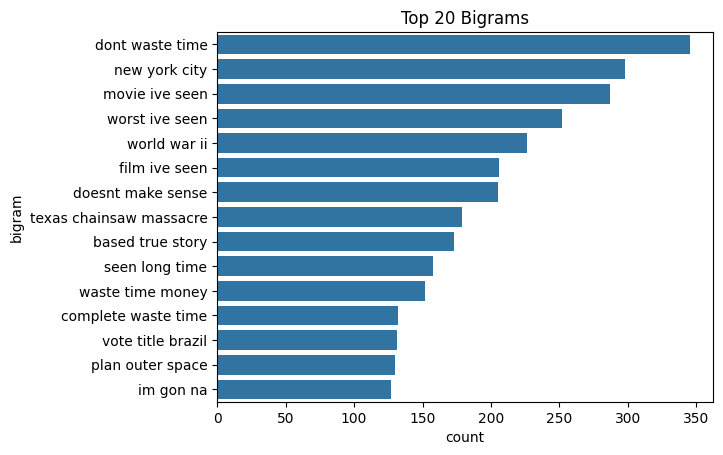

In [ ]:
top_bigrams = get_top_ngrams(df_unsup_clean['clean_text'], (3,3))
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

sns.barplot(data=bigram_df, x='count', y='bigram')
plt.title("Top 20 3-grams")
plt.show()

# Vectorisation

In [18]:
df_unsup_model= df_unsup_clean[['clean_text', 'tokens']]

In [ ]:
df_unsup_model.head()

### Avec Tfidf et Count vectorizer (Bag Word)

In [19]:
max_features=500
ngram_range = (1, 2)
#
vectorizer_tfidf = TfidfVectorizer(use_idf = True, # use_idf : Activates the IDF (Inverse Document Frequency) factor, which penalises words that occur too frequently in all documents.
                             strip_accents='ascii', #removes accents (diacritics) from characters.
                             ngram_range=ngram_range,
                             max_features=max_features,
                             max_df=0.8,  # Ignore terms that appear in more than 80% of documents
                             )
vectorizer_BagWord = CountVectorizer(max_features=max_features)

In [20]:
X_tfidf= vectorizer_tfidf.fit_transform(df_unsup_model["clean_text"])
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

In [21]:
X_BagWord = vectorizer_BagWord.fit_transform(df_unsup_model["clean_text"])
feature_names_BagWord = vectorizer_BagWord.get_feature_names_out()

In [22]:
scaler = StandardScaler()

In [23]:
X_tfidf_scaled = scaler.fit_transform(X_tfidf.toarray())
X_BagWord_scaled = scaler.fit_transform(X_BagWord.toarray())

In [24]:
pca = PCA(n_components=5, random_state=42)
df_tfidf_reduced = pca.fit_transform(X_tfidf_scaled)

In [25]:
pca = PCA(n_components=5, random_state=42)
df_BagWord_reduced = pca.fit_transform(X_BagWord_scaled)

#### vectorisation avec Word2vec

In [26]:
model_w2v = Word2Vec(
    sentences=df_unsup_model['tokens'].tolist(),  # liste de listes de mots
    vector_size=100,         # taille du vecteur de chaque mot
    window=3,                # fenêtre de contexte
    min_count=1,             # mots rares ignorés
    workers=4,               # threads
    sg=0                     # 1 = Skip-gram, 0 = CBOW
)

In [29]:
len(model_w2v.wv.index_to_key)

159016

In [46]:
def vectoriser_commentaire(tokens, model):
    vecteurs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecteurs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecteurs, axis=0)

In [47]:
X_word2vec = np.array([vectoriser_commentaire(tokens, model_w2v) for tokens in df_unsup_model['tokens'].tolist()])
feature_names_word2vec = list(model_w2v.wv.index_to_key)

In [ ]:
#pca = PCA(n_components=5, random_state=42)
#df_word2vec_reduced = pca.fit_transform(X_word2vec)

# Modélisation

##### Kmeans avec TFIDF

In [ ]:
k_tfidf = 2
kmeans_tfidf = KMeans(n_clusters=k_tfidf, random_state=42)
kmeans_tfidf.fit(df_tfidf_reduced)

<ipython-input-51-1788040180>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsup_model['Cluster_tfidf'] = clusters_tfidf


In [ ]:
print(82 * "_")

# Silhouette Score
sil_score = metrics.silhouette_score(df_tfidf_reduced, kmeans_tfidf.labels_, metric="euclidean", sample_size=300)
# Davies-Bouldin Index
db_score = metrics.davies_bouldin_score(df_tfidf_reduced, kmeans_tfidf.labels_)
# Calinski-Harabasz Index
ch_score = metrics.calinski_harabasz_score(df_tfidf_reduced, kmeans_tfidf.labels_)
print(f"Silhouette Score:        {sil_score:.3f}")
print(f"Davies-Bouldin Index:    {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(82 * "_")


__________________________________________________________________________________
Silhouette Score:        0.169
Davies-Bouldin Index:    2.094
Calinski-Harabasz Score: 9888.549
__________________________________________________________________________________


In [54]:
# Définition de la grille des hyperparamètres
param_grid = {
    'n_clusters': [2, 3, 4],
    'max_iter': [100, 300, 500],
    'tol': [1e-2, 1e-3, 1e-4]
}

In [ ]:
############################### Optimisation #################################

# Initialisation des meilleures valeurs
best_score = -1
best_model = None
best_params = None

# Parcours de toutes les combinaisons de la grille
for params in ParameterGrid(param_grid):
    model = KMeans(
        n_clusters=params['n_clusters'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        random_state=42
    )
    labels = model.fit_predict(df_tfidf_reduced)

    # Calcul du silhouette score comme critère d'évaluation
    score = metrics.silhouette_score(df_tfidf_reduced, labels)

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

# Affichage du meilleur modèle et des meilleurs paramètres
print("Meilleur Silhouette Score :", best_score)
print("Meilleurs hyperparamètres :", best_params)


Meilleur Silhouette Score : 0.1634778642872647
Meilleurs hyperparamètres : {'max_iter': 100, 'n_clusters': 2, 'tol': 0.001}


In [32]:
Best_kmeans_tfidf = KMeans(n_clusters=2,max_iter=100, tol=0.001,random_state=42)
Best_kmeans_tfidf.fit(df_tfidf_reduced)

KMeans(max_iter=100, n_clusters=2, random_state=42, tol=0.001)

In [34]:
clusters_tfidf = Best_kmeans_tfidf.fit_predict(df_tfidf_reduced)
df_unsup_model['Cluster_tfidf'] = clusters_tfidf

<ipython-input-34-111056266>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsup_model['Cluster_tfidf'] = clusters_tfidf


##### Kmeans avec BagWord

In [ ]:
k_BagWord = 2
kmeans_BagWord = KMeans(n_clusters=k_BagWord, random_state=42)
kmeans_BagWord.fit(df_BagWord_reduced)
clusters_BagWord = kmeans_BagWord.fit_predict(df_BagWord_reduced)
df_unsup_model['Cluster_BagWord'] = clusters_BagWord

<ipython-input-27-2947043854>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsup_model['Cluster_BagWord'] = clusters_BagWord


In [ ]:
print(82 * "_")

# Silhouette Score
sil_score = metrics.silhouette_score(df_BagWord_reduced, kmeans_BagWord.labels_, metric="euclidean", sample_size=300)
# Davies-Bouldin Index
db_score = metrics.davies_bouldin_score(df_BagWord_reduced, kmeans_BagWord.labels_)
# Calinski-Harabasz Index
ch_score = metrics.calinski_harabasz_score(df_BagWord_reduced, kmeans_BagWord.labels_)
print(f"Silhouette Score:        {sil_score:.3f}")
print(f"Davies-Bouldin Index:    {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(82 * "_")


__________________________________________________________________________________
Silhouette Score:        0.538
Davies-Bouldin Index:    1.068
Calinski-Harabasz Score: 32021.403
__________________________________________________________________________________


In [ ]:
############################### Optimisation #################################
# Initialisation des meilleures valeurs
best_score = -1
best_model = None
best_params = None

# Parcours de toutes les combinaisons de la grille
for params in ParameterGrid(param_grid):
    model = KMeans(
        n_clusters=params['n_clusters'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        random_state=42
    )
    labels = model.fit_predict(df_BagWord_reduced)

    # Calcul du silhouette score comme critère d'évaluation
    score = metrics.silhouette_score(df_BagWord_reduced, labels)

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

# Affichage du meilleur modèle et des meilleurs paramètres
print("Meilleur Silhouette Score :", best_score)
print("Meilleurs hyperparamètres :", best_params)


Meilleur Silhouette Score : 0.539421235107661
Meilleurs hyperparamètres : {'max_iter': 100, 'n_clusters': 2, 'tol': 0.01}


In [35]:
Best_kmeans_BagWord = KMeans(n_clusters=2,max_iter=100, tol=0.01,random_state=42)
Best_kmeans_BagWord.fit(df_BagWord_reduced)

KMeans(max_iter=100, n_clusters=2, random_state=42, tol=0.01)

In [36]:
clusters_BagWord = Best_kmeans_BagWord.fit_predict(df_BagWord_reduced)
df_unsup_model['Cluster_BagWord'] = clusters_BagWord

##### Kmeans avec Word2vec

In [48]:
k_word2vec= 2
kmeans_word2vec = KMeans(n_clusters=k_word2vec, random_state=42)
kmeans_word2vec.fit(X_word2vec)
clusters_word2vec = kmeans_word2vec.fit_predict(X_word2vec)
df_unsup_model['Cluster_word2vec'] = clusters_word2vec

In [49]:
print(82 * "_")

# Silhouette Score
sil_score = metrics.silhouette_score(X_word2vec, kmeans_word2vec.labels_, metric="euclidean", sample_size=300)
# Davies-Bouldin IndexX
db_score = metrics.davies_bouldin_score(X_word2vec, kmeans_word2vec.labels_)
# Calinski-Harabasz Index
ch_score = metrics.calinski_harabasz_score(X_word2vec, kmeans_word2vec.labels_)
print(f"Silhouette Score:        {sil_score:.3f}")
print(f"Davies-Bouldin Index:    {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(82 * "_")

__________________________________________________________________________________
Silhouette Score:        0.153
Davies-Bouldin Index:    2.205
Calinski-Harabasz Score: 9557.749
__________________________________________________________________________________


In [55]:
############################### Optimisation #################################
# Initialisation des meilleures valeurs
best_score = -1
best_model = None
best_params = None

# Parcours de toutes les combinaisons de la grille
for params in ParameterGrid(param_grid):
    model = KMeans(
        n_clusters=params['n_clusters'],
        max_iter=params['max_iter'],
        tol=params['tol'],
        random_state=42
    )
    labels = model.fit_predict(X_word2vec)

    # Calcul du silhouette score comme critère d'évaluation
    score = metrics.silhouette_score(X_word2vec, labels)

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

# Affichage du meilleur modèle et des meilleurs paramètres
print("Meilleur Silhouette Score :", best_score)
print("Meilleurs hyperparamètres :", best_params)


Meilleur Silhouette Score : 0.14312369
Meilleurs hyperparamètres : {'max_iter': 100, 'n_clusters': 2, 'tol': 0.0001}


In [56]:
Best_kmeans_word2vec = KMeans(n_clusters=2,max_iter=100, tol=0.0001,random_state=42)
Best_kmeans_word2vec.fit(X_word2vec)

KMeans(max_iter=100, n_clusters=2, random_state=42)

In [57]:
metrics.silhouette_score(X_word2vec, Best_kmeans_word2vec.fit_predict(X_word2vec))

0.14312369

In [58]:
clusters_word2vec = Best_kmeans_word2vec.fit_predict(X_word2vec)
df_unsup_model['Cluster_word2vec'] = clusters_word2vec

## Visualisation

In [42]:
def plot_top_words_per_cluster(X_tfidf, labels, feature_names, cluster_id, top_n=20, mode="wordcloud"):
    # Sélectionner les documents du cluster
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_tfidf = X_tfidf[cluster_indices]

    # Moyenne des TF-IDF dans le cluster
    mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()

    # Trier les mots par importance moyenne
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [mean_tfidf[i] for i in top_indices]
    word_dict = dict(zip(top_words, top_scores))

    # Visualisation
    if mode == "wordcloud":
        wc = WordCloud(width=800, height=400, background_color='white')
        plt.figure(figsize=(10, 5))
        plt.imshow(wc.generate_from_frequencies(word_dict), interpolation='bilinear')
        plt.title(f"Cluster {cluster_id} - WordCloud")
        plt.axis('off')
        plt.show()

    elif mode == "bar":
        plt.figure(figsize=(10, 4))
        plt.barh(top_words[::-1], top_scores[::-1], color='skyblue')
        plt.title(f"Cluster {cluster_id} - Top {top_n} mots TF-IDF")
        plt.xlabel("Poids moyen TF-IDF")
        plt.tight_layout()
        plt.show()


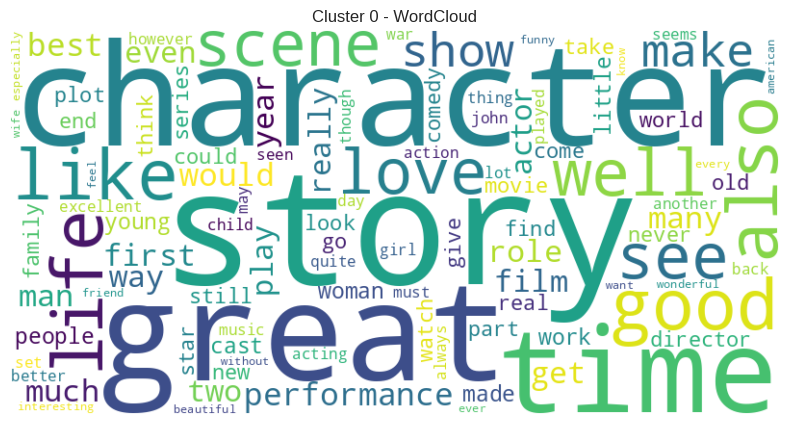

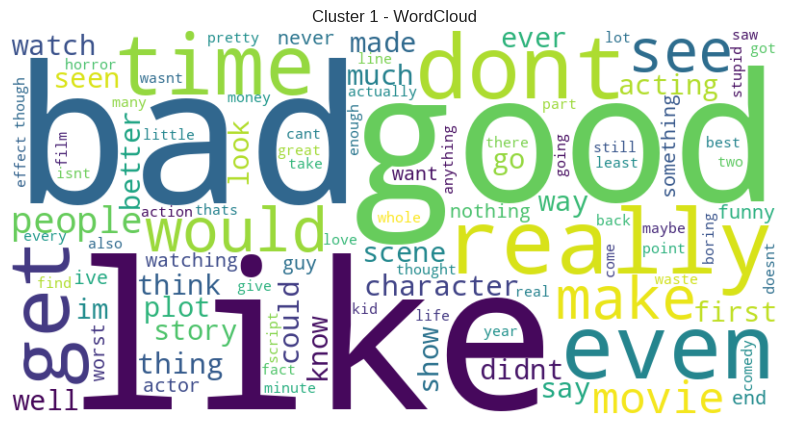

In [44]:
for cluster_id in range(2):
    plot_top_words_per_cluster(X_tfidf, clusters_tfidf, feature_names_tfidf, cluster_id, top_n=100, mode="wordcloud")


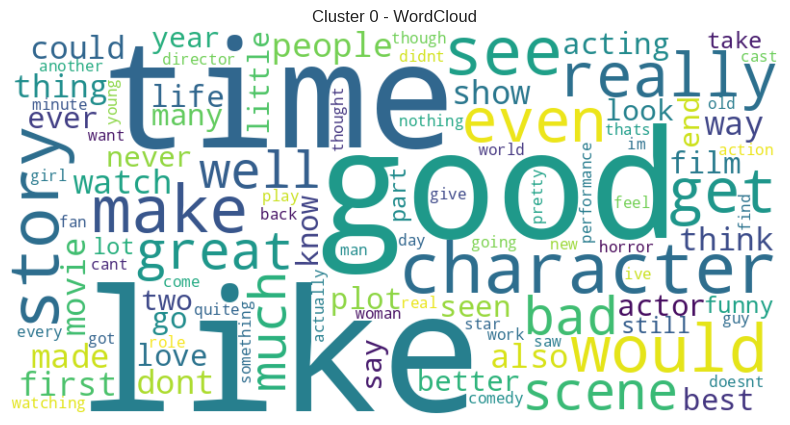

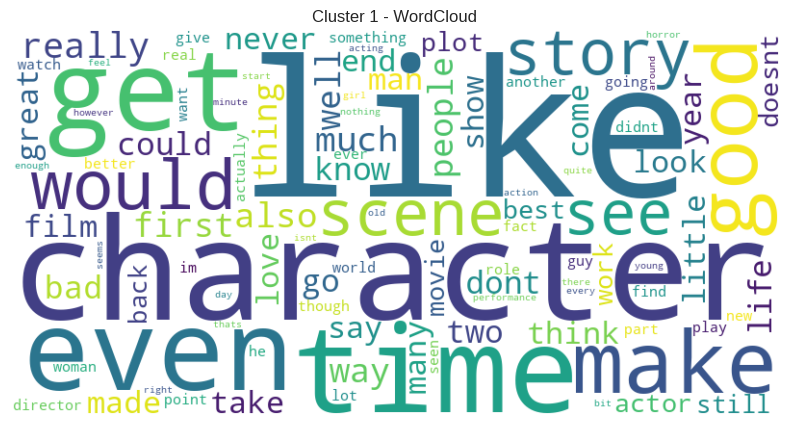

In [45]:
for cluster_id in range(2):
    plot_top_words_per_cluster(X_BagWord, clusters_BagWord, feature_names_BagWord, cluster_id, top_n=100, mode="wordcloud")


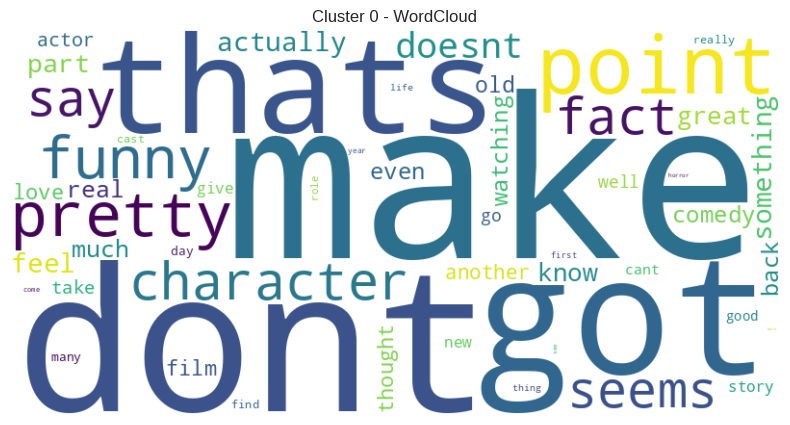

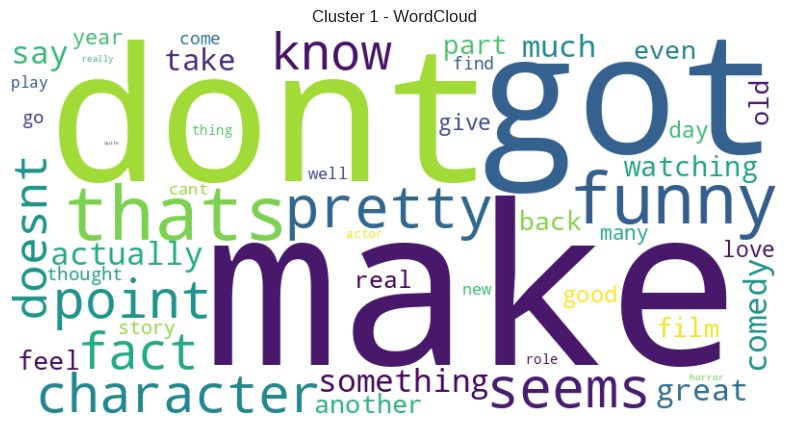

In [59]:
for cluster_id in range(2):
    plot_top_words_per_cluster(X_word2vec, clusters_word2vec, feature_names_word2vec, cluster_id, top_n=100, mode="wordcloud")


# Pipepline

In [ ]:
class RemoveWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words_to_remove=None):
        self.words_to_remove = words_to_remove or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = r'\b(?:' + '|'.join(re.escape(word.lower()) for word in self.words_to_remove) + r')\b'
        return X.apply(lambda x: re.sub(pattern, '', x.lower(), flags=re.IGNORECASE)).str.replace(r'\s+', ' ', regex=True).str.strip()

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, reduction_technique='lem', language='english'):
        self.reduction_technique = reduction_technique
        self.language = language

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stop_words = set(stopwords.words(self.language))
        lemmatizer = WordNetLemmatizer()

        def clean(text):
            text = text.lower()
            text = ''.join(c for c in text if c not in string.punctuation)
            tokens = nltk.word_tokenize(text)
            tokens = [w for w in tokens if w not in stop_words]
            if self.reduction_technique == 'lem':
                tokens = [lemmatizer.lemmatize(w) for w in tokens]
            return ' '.join(tokens)

        return X.apply(clean)


In [ ]:
pipeline_tfidf = Pipeline([
        ('remove_words', RemoveWordsTransformer(words_to_remove=['film', 'movie', 'br', 'one'])),
        ('clean_text', TextCleaner(reduction_technique='lem')),
        ('tfidf', TfidfVectorizer(
            use_idf=True,
            strip_accents='ascii',
            max_df=0.8,
            max_features=500,
            ngram_range=(1,2)
        )),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=5, random_state=42)),
        ('kmeans', KMeans(n_clusters=2, random_state=42, max_iter=100, tol=0.001))
    ])

In [ ]:
pipeline_BagWord = Pipeline([
        ('remove_words', RemoveWordsTransformer(words_to_remove=['film', 'movie', 'br', 'one'])),
        ('clean_text', TextCleaner(reduction_technique='lem')),
        ('BagWord', CountVectorizer(max_features=max_features)),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=5, random_state=42)),
        ('kmeans', KMeans(n_clusters=2, random_state=42, max_iter=100, tol=0.001))
    ])

In [ ]:
pipeline_tfidf.fit(df_unsup['text'])

In [ ]:
pipeline_BagWord.fit(df_unsup['text'])

Pipeline(steps=[('remove_words',
                 RemoveWordsTransformer(words_to_remove=['film', 'movie', 'br',
                                                         'one'])),
                ('clean_text', TextCleaner()),
                ('BagWord', CountVectorizer(max_features=500)),
                ('scaler', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components=5, random_state=42)),
                ('kmeans',
                 KMeans(max_iter=100, n_clusters=2, random_state=42,
                        tol=0.001))])

In [ ]:
joblib.dump(pipeline_tfidf, 'pipeline_tfidf_clustering.joblib')

['pipeline_tfidf_clustering.joblib']

In [ ]:
joblib.dump(pipeline_BagWord, 'pipeline_BagWord_clustering.joblib')

['pipeline_BagWord_clustering.joblib']

In [60]:
class RemoveWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words_to_remove=None):
        self.words_to_remove = words_to_remove or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = r'\b(?:' + '|'.join(re.escape(word.lower()) for word in self.words_to_remove) + r')\b'
        return X.apply(lambda x: re.sub(pattern, '', x.lower(), flags=re.IGNORECASE)).str.replace(r'\s+', ' ', regex=True).str.strip()

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, reduction_technique='lem', language='english'):
        self.reduction_technique = reduction_technique
        self.language = language

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stop_words = set(stopwords.words(self.language))
        lemmatizer = WordNetLemmatizer()

        def clean(text):
            text = text.lower()
            text = ''.join(c for c in text if c not in string.punctuation)
            tokens = nltk.word_tokenize(text)
            tokens = [w for w in tokens if w not in stop_words]
            if self.reduction_technique == 'lem':
                tokens = [lemmatizer.lemmatize(w) for w in tokens]
            return tokens

        return X.apply(clean)

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.vector_size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.model.wv[token] for token in tokens if token in self.model.wv] or
                    [np.zeros(self.vector_size)], axis=0)
            for tokens in X
        ])

pipeline_word2vec = Pipeline([
        ('remove_words', RemoveWordsTransformer(words_to_remove=['film', 'movie', 'br', 'one'])),
        ('clean_text', TextCleaner(reduction_technique='lem')),
        ('word2vec_vectorizer', Word2VecVectorizer(model=model_w2v)),
        ('kmeans', KMeans(n_clusters=2, random_state=42, max_iter=100, tol=0.0001))
    ])

In [61]:
pipeline_word2vec.fit(df_unsup['text'])

Pipeline(steps=[('remove_words',
                 RemoveWordsTransformer(words_to_remove=['film', 'movie', 'br',
                                                         'one'])),
                ('clean_text', TextCleaner()),
                ('word2vec_vectorizer',
                 Word2VecVectorizer(model=<gensim.models.word2vec.Word2Vec object at 0x7845b0e63950>)),
                ('kmeans',
                 KMeans(max_iter=100, n_clusters=2, random_state=42))])

In [62]:
joblib.dump(pipeline_word2vec, 'pipeline_word2vec_clustering.joblib')

['pipeline_word2vec_clustering.joblib']

HDBSCAN

In [64]:
hdb = HDBSCAN(min_cluster_size=15)
hdb.fit(df_tfidf_reduced)

HDBSCAN(min_cluster_size=15)

In [68]:
labels

array([ 0,  0, -1, ..., -1, -1,  0])

In [69]:
# Labels attribués par le modèle
labels = hdb.labels_

# Nombre de clusters réels (excluant les -1, considérés comme "bruit")
n_clusters = len(np.unique(labels[labels !=-1]))

print(f"Nombre de clusters créés : {n_clusters}")


Nombre de clusters créés : 2


In [70]:
metrics.silhouette_score(df_tfidf_reduced, hdb.labels_, metric="euclidean", sample_size=300)

0.1300321096650029

In [71]:
clusters_hbd = hdb.fit_predict(df_tfidf_reduced)
df_unsup_model['Cluster_hbd'] = clusters_hbd

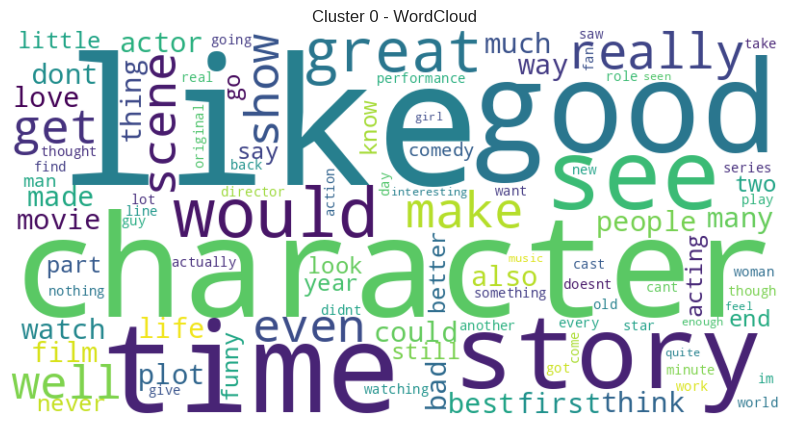

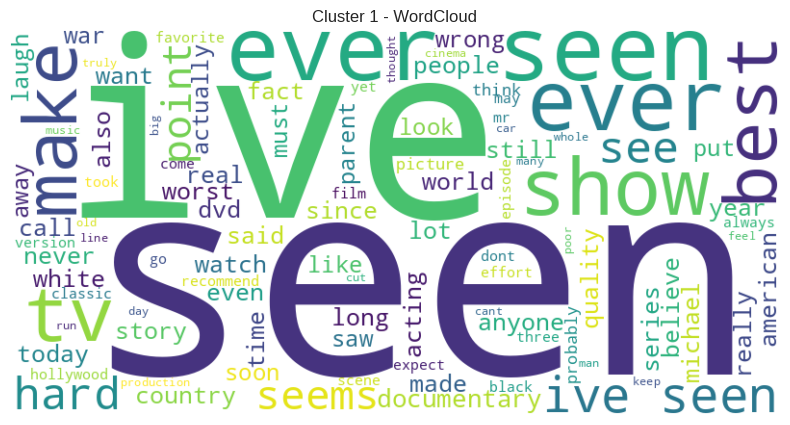

In [74]:
for cluster_id in range(n_clusters):
    plot_top_words_per_cluster(X_tfidf, clusters_hbd, feature_names_tfidf, cluster_id, top_n=100, mode="wordcloud")


In [75]:
hdb1 = HDBSCAN(min_cluster_size=15)
hdb1.fit(df_BagWord_reduced)

HDBSCAN(min_cluster_size=15)

In [78]:
# Labels attribués par le modèle
labels1 = hdb1.labels_

# Nombre de clusters réels (excluant les -1 → les points considérés comme "bruit")
n_clusters1 = len(np.unique(labels[labels1 != -1]))

print(f"Nombre de clusters créés : {n_clusters1}")


Nombre de clusters créés : 3


In [84]:
metrics.silhouette_score(df_BagWord_reduced, labels1, metric="euclidean", sample_size=300)

-0.36509821863152453

In [80]:
clusters_hbd1 = hdb1.fit_predict(df_BagWord_reduced)
df_unsup_model['Cluster_hbd1'] = clusters_hbd1

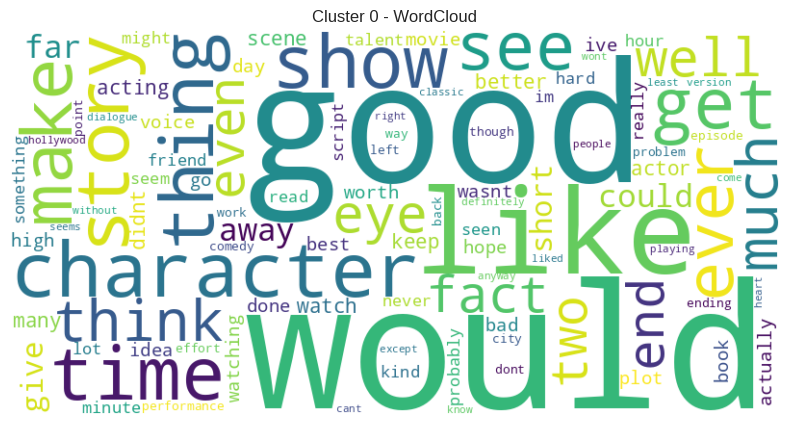

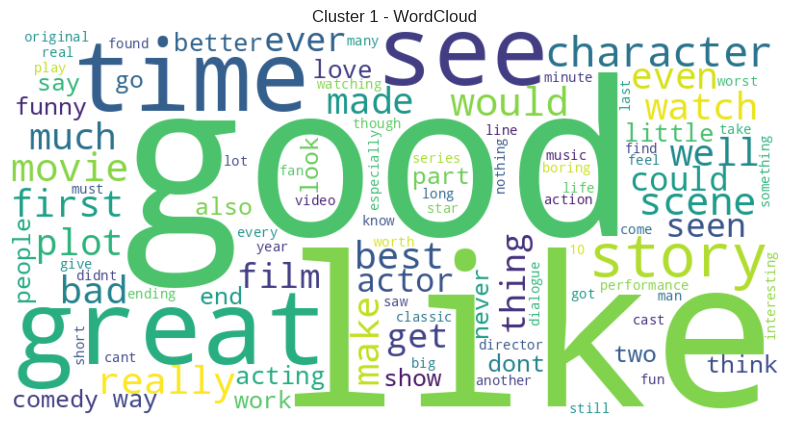

ZeroDivisionError: float division by zero

In [95]:
for cluster_id in range(n_clusters1):
    plot_top_words_per_cluster(X_BagWord, clusters_hbd1, feature_names_BagWord, cluster_id, top_n=100, mode="wordcloud")

In [92]:
hdb2 = HDBSCAN(min_cluster_size=5)
hdb2.fit(X_word2vec)

HDBSCAN()

In [93]:
# Labels attribués par le modèle
labels2 = hdb2.labels_

# Nombre de clusters réels (excluant les -1 → les points considérés comme "bruit")
n_clusters2 = len(np.unique(labels[labels2 != -1]))

print(f"Nombre de clusters créés : {n_clusters2}")


Nombre de clusters créés : 3


In [94]:
metrics.silhouette_score(X_word2vec, labels2, metric="euclidean", sample_size=300)

0.08302185

In [96]:
clusters_hbd2 = hdb2.fit_predict(X_word2vec)
df_unsup_model['Cluster_hbd2'] = clusters_hbd2

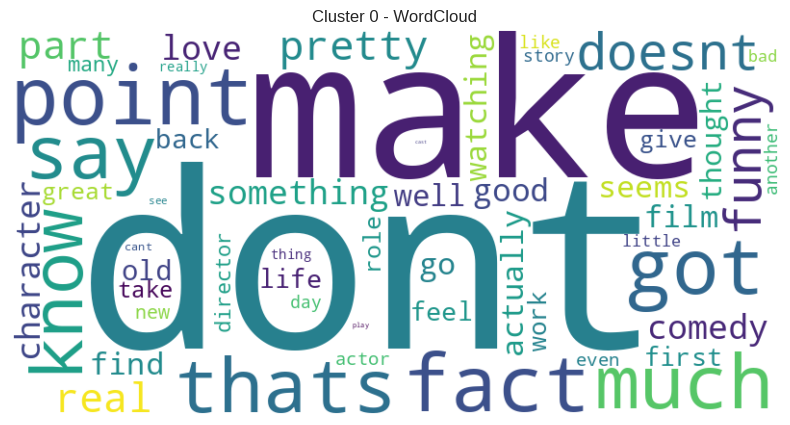

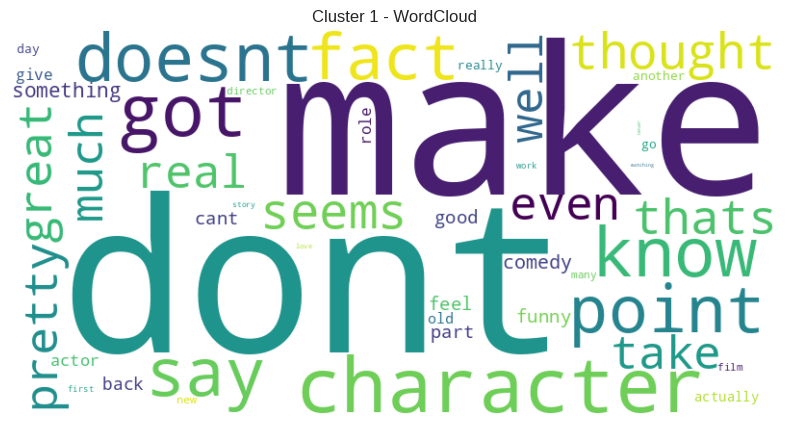

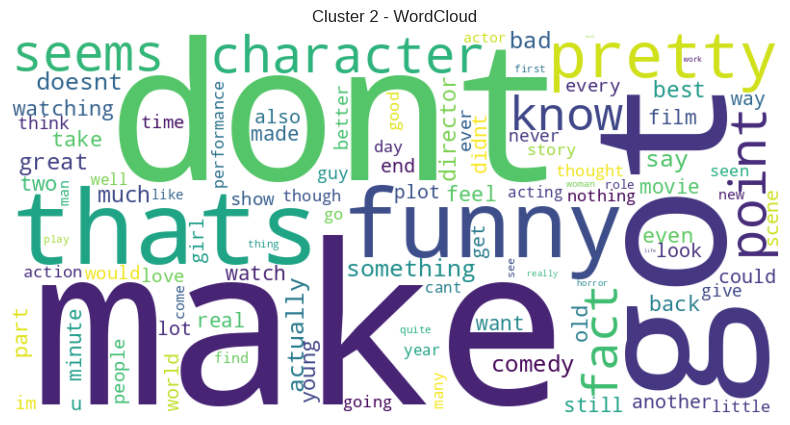

In [97]:
for cluster_id in range(n_clusters2):
    plot_top_words_per_cluster(X_word2vec, clusters_hbd2, feature_names_word2vec, cluster_id, top_n=100, mode="wordcloud")